In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
%cd /content

/content


In [46]:
!cp -r /content/drive/MyDrive/petfinder ./

In [47]:
%cd petfinder

/content/petfinder


In [4]:
!unzip -qq petfinder-adoption-prediction.zip

In [10]:
!unzip -qq /content/petfinder/glove.840B.300d.txt.zip

replace glove.840B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [48]:
!unzip -qq /content/petfinder/archive.zip

In [49]:
import cv2
import pandas as pd
import numpy as np
import os
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from keras.applications.resnet import preprocess_input, ResNet101
from keras.utils import to_categorical
from dataset import My_Custom_Generator

In [50]:
path = 'train/train.csv'
df_pet = pd.read_csv(path)
df = df_pet[['PetID','PhotoAmt','AdoptionSpeed','Description']]
df = df[df['PhotoAmt']>0]
df.head()

,PetID,PhotoAmt,AdoptionSpeed,Description
0,86e1089a3,1.0,2,Nibble is a 3+ month old ball of cuteness. He ...
1,6296e909a,2.0,0,I just found it alone yesterday near my apartm...
2,3422e4906,7.0,3,Their pregnant mother was dumped by her irresp...
3,5842f1ff5,8.0,2,"Good guard dog, very alert, active, obedience ..."
4,850a43f90,3.0,2,This handsome yet cute boy is up for adoption....


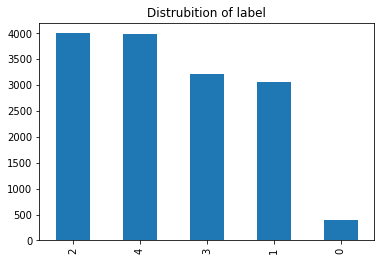

In [51]:
df['AdoptionSpeed'].value_counts().plot(kind='bar')
plt.title("Distrubition of label")
plt.show()

# CV

In [10]:
def resize_to_square(im):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def load_image(path, pet_id):
    image = cv2.imread(f'{path}{pet_id}-1.jpg')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image


In [ ]:
# img_size = 256
# batch_size = 16


In [ ]:
# pet_ids = df['PetID'].values
# n_batches = len(pet_ids) // batch_size + 1

In [11]:
X = []
y = []
# max_images = 100
for index, row in df.iterrows():
    # img = load_image("train_images/", row['PetID'])
    for count in range(int(row['PhotoAmt'])):
      name = f"{row['PetID']}-{count+1}.jpg"
      imgName = os.path.join("train_images/", name)
      X.append(imgName)
      y.append(row['AdoptionSpeed'])
    # if index > max_images:
    #     break


In [12]:
len(X)

58311

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

batch_size = 32
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

my_training_batch_generator = My_Custom_Generator(x_train, y_train, batch_size)
my_validation_batch_generator = My_Custom_Generator(x_val, y_val, batch_size)
print(my_validation_batch_generator)

In [38]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D, Dense, Conv2D, MaxPooling2D
import keras.backend as K
import keras
epochs = 100
lr = 0.0001
decay_rate = lr / epochs
n_classes = 5
inp = Input((256,256,3))

x = Conv2D(128, (3, 3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
backbone = ResNet101(include_top = False, weights="imagenet")(encoded)
# for layer in backbone.layers:
#     layer.trainable = False
x = GlobalAveragePooling2D()(backbone)
x = Dense(4096)(x)
x = Dense(4096)(x)
out = Dense(n_classes, activation='softmax')(x)
m = Model(inp,out)

m.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr, decay=decay_rate), metrics= 'accuracy')

In [39]:
m.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 256, 256, 128)     3584      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 128, 128, 64)      73792     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 64, 64, 3)         1731      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 32, 32, 3)         0  

In [40]:
from keras.callbacks import ModelCheckpoint


filepath="/content/drive/MyDrive/petfinder/weights"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

m.fit_generator(generator = my_training_batch_generator,
                steps_per_epoch = int(3800 // batch_size),
                epochs=epochs, 
                validation_data = my_validation_batch_generator,
                validation_steps = int(950 // batch_size),
                callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
118/118 [==============================] - 143s 1s/step - loss: 2.9604 - accuracy: 0.2213 - val_loss: 150.0901 - val_accuracy: 0.1832

Epoch 00001: val_accuracy improved from -inf to 0.18319, saving model to /content/drive/MyDrive/petfinder/weights
INFO:tensorflow:Assets written to: /content/drive/MyDrive/petfinder/weights/assets
Epoch 2/100
118/118 [==============================] - 133s 1s/step - loss: 2.0895 - accuracy: 0.2590 - val_loss: 7488.6030 - val_accuracy: 0.3028

Epoch 00002: val_accuracy improved from 0.18319 to 0.30280, saving model to /content/drive/MyDrive/petfinder/weights
INFO:tensorflow:Assets written to: /content/drive/MyDrive/petfinder/weights/assets
Epoch 3/100
118/118 [==============================] - 132s 1s/step - loss: 1.9428 - accuracy: 0.2408 - val_loss: 19875.1602 - val_accuracy: 0.2694

Epoch 00003: val_accuracy did not improve from 0.30280
Epoch 4/100
118/118 [==============================] - 129s 1s/step - loss: 1.5473 - accuracy: 0.2658 - 

KeyboardInterrupt: ignored

In [ ]:
m.save("/content/drive/MyDrive/petfinder/weights/my_model")


INFO:tensorflow:Assets written to: /content/drive/MyDrive/petfinder/weights/my_model/assets


# NLP

In [52]:
from nltk.tokenize import TweetTokenizer
import nltk
isascii = lambda s: len(s) == len(s.encode())
tknzr = TweetTokenizer()
import jieba
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem.lancaster import LancasterStemmer
lc = LancasterStemmer()
from nltk.stem import SnowballStemmer
sb = SnowballStemmer("english")
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [53]:
def custom_tokenizer(text):
    init_doc = tknzr.tokenize(text)
    retval = []
    for t in init_doc:
        if isascii(t): 
            retval.append(t)
        else:
            for w in t:
                retval.append(w)
    return retval

def build_emb_matrix(word_dict, emb_dict):
    embed_size = 300
    nb_words = len(word_dict)+1000
    nb_oov = 0
    embedding_matrix = np.zeros((nb_words, embed_size), dtype=np.float32)
    unknown_vector = np.zeros((embed_size,), dtype=np.float32) - 1.
    for key in tqdm(word_dict):
        word = key
        embedding_vector = emb_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.lower()
        embedding_vector = emb_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.upper()
        embedding_vector = emb_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.capitalize()
        embedding_vector = emb_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = ps.stem(key)
        embedding_vector = emb_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lc.stem(key)
        embedding_vector = emb_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = sb.stem(key)
        embedding_vector = emb_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        nb_oov+=1
        embedding_matrix[word_dict[key]] = unknown_vector                    
    return embedding_matrix, nb_words, nb_oov


In [54]:
df['Description'] = df['Description'].fillna(' ')


In [55]:
english_desc, chinese_desc = [], []
tokens = set()
word_dict = {}
pos_count, word_count = 1, 1 # starts from 1, 0 for padding token
pos_dict = {}
eng_sequences = []
pos_sequences = []
for i in range(len(df)):
    e_d, c_d, eng_seq, pos_seq = [], [], [], []
    doc = custom_tokenizer(df['Description'].iloc[i])
    for token in doc:
        if not isascii(token):
            c_d.append(token)
        else:
            e_d.append(token)
            if token not in word_dict:
                word_dict[token] = word_count
                word_count +=1
    english_desc.append(' '.join(e_d))
    chinese_desc.append(' '.join(c_d))
    pos_seq = nltk.pos_tag(e_d)
    for t in pos_seq:
        if t[1] not in pos_dict:
            pos_dict[t[1]] = pos_count
            pos_count += 1
    pos_seq = [pos_dict[t[1]] for t in pos_seq]
    eng_seq = [word_dict[t] for t in e_d]
    if len(eng_seq)==0:
        eng_seq.append(0)
        pos_seq.append(0)
    eng_sequences.append(eng_seq)
    pos_sequences.append(pos_seq)


In [56]:
df['English_desc'] = english_desc
df['Chinese_desc'] = chinese_desc

df['e_description_len'] = df['English_desc'].apply(lambda x:len(x))
df['e_description_word_len'] = df['English_desc'].apply(lambda x: len(x.split(' ')))
df['e_description_word_unique'] = df['English_desc'].apply(lambda x: len(set(x.split(' '))))

df['c_description_len'] = df['Chinese_desc'].apply(lambda x:len(x))
df['c_description_word_len'] = df['Chinese_desc'].apply(lambda x:len(x.split(' ')))
df['c_description_word_unique'] = df['Chinese_desc'].apply(lambda x: len(set(x)))

df['description_len'] = df['Description'].apply(lambda x:len(x))
df['description_word_len'] = df['Description'].apply(lambda x: len(x.split(' ')))
df[df['c_description_len']>0].head()

,PetID,PhotoAmt,AdoptionSpeed,Description,English_desc,Chinese_desc,e_description_len,e_description_word_len,e_description_word_unique,c_description_len,c_description_word_len,c_description_word_unique,description_len,description_word_len
14,c02be41e6,2.0,2,"Lost Dog Found (Bandar Menjalara, Kepong／Taman...","Lost Dog Found ( Bandar Menjalara , Kepong Tam...",／ 迷 途 犬 被 尋 獲 甲 洞 孟 加 拉 惹 ／ 武 吉 馬 魯 里 ／ 小 狗 被 ...,397,78,55,197,99,67,485,67
64,b0dec8779,21.0,3,~ PLEASE CLICK ON OUR PHOTOS FOR A CLEARER VIE...,~ PLEASE CLICK ON OUR PHOTOS FOR A CLEARER VIE...,♦ ♦ • •,813,169,116,7,4,3,874,133
69,ef14861df,3.0,4,Jasz is a very friendly and well-behaved Schna...,Jasz is a very friendly and well-behaved Schna...,’ ’,158,32,27,3,2,2,156,28
72,1e62e6022,5.0,1,3 month-old male puppy for adoption. a cross b...,3 month-old male puppy for adoption . a cross ...,♥,236,50,41,1,1,1,230,43
141,2ac4dd8c2,5.0,3,Name: Pillo aka Lilo Attitude: Was named Pillo...,Name : Pillo aka Lilo Attitude : Was named Pil...,☺ ️ 😀 😃 😄,1166,241,156,9,5,6,1127,195


In [19]:
print(len(eng_sequences))
print(len(pos_sequences))
nb_pos = len(pos_dict)
print(nb_pos)


14652
14652
45


In [57]:
import gc

def load_glove():
    EMBEDDING_FILE = 'glove.840B.300d.txt'

    def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(get_coefs(*o.split(" ")) for o in (open(EMBEDDING_FILE)))
    return embeddings_index

glove_emb = load_glove()

embedding_matrix, nb_words, nb_oov = build_emb_matrix(word_dict, glove_emb)
print(nb_words, nb_oov)
del glove_emb
gc.collect()


100%|██████████| 28337/28337 [00:00<00:00, 76142.28it/s]

29337 3994


34

In [58]:
from sklearn.model_selection import StratifiedKFold,KFold,GroupKFold

n_splits = 5
# kfold = GroupKFold(n_splits=n_splits)
split_index = []
# for train_idx, valid_idx in kfold.split(train, train['AdoptionSpeed'], train['RescuerID']):
#     split_index.append((train_idx, valid_idx))

kfold = StratifiedKFold(n_splits=n_splits, random_state=1991)
for train_idx, valid_idx in kfold.split(df, df['AdoptionSpeed']):
    split_index.append((train_idx, valid_idx))
print(len(split_index))
print(split_index)

5
[(array([ 2803,  2805,  2806, ..., 14649, 14650, 14651]), array([   0,    1,    2, ..., 3037, 3087, 3098])), (array([    0,     1,     2, ..., 14649, 14650, 14651]), array([2803, 2805, 2806, ..., 5994, 6048, 6076])), (array([    0,     1,     2, ..., 14649, 14650, 14651]), array([5721, 5735, 5737, ..., 8965, 8970, 8971])), (array([    0,     1,     2, ..., 14649, 14650, 14651]), array([ 8222,  8243,  8279, ..., 11895, 11908, 11910])), (array([    0,     1,     2, ..., 11895, 11908, 11910]), array([11382, 11512, 11523, ..., 14649, 14650, 14651]))]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [59]:
df.columns

Index(['PetID', 'PhotoAmt', 'AdoptionSpeed', 'Description', 'English_desc',
       'Chinese_desc', 'e_description_len', 'e_description_word_len',
       'e_description_word_unique', 'c_description_len',
       'c_description_word_len', 'c_description_word_unique',
       'description_len', 'description_word_len'],
      dtype='object')

In [60]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import os
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, GRU
import matplotlib.pyplot as plt


In [61]:
AdoptionSpeed = df['AdoptionSpeed']
labels = to_categorical(AdoptionSpeed)


In [62]:
descriptions = df['English_desc']
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(descriptions)
word_index = tokenizer.word_index

print('Found %s unique tokens' % len(word_index))
sequences = tokenizer.texts_to_sequences(descriptions)


Found 19929 unique tokens


In [63]:
max_len = 100
max_words = 10000
training_sample = 10000
val_sample = 12000
padded_sequences = pad_sequences(sequences, maxlen=max_len)
print("Shape of data: ", padded_sequences.shape)
print("Shape of labels: ", labels.shape)


Shape of data:  (14652, 100)
Shape of labels:  (14652, 5)


In [64]:
indices = np.arange(df.shape[0])
np.random.shuffle(indices)
padded_sequences = padded_sequences[indices]
labels = labels[indices]

x_train = padded_sequences[:training_sample]
y_train = labels[:training_sample]
x_val = padded_sequences[training_sample: val_sample]
y_val = labels[training_sample: val_sample]
x_test = padded_sequences[val_sample: ]
y_test = labels[val_sample: ]


In [65]:
embeddings_index = {}
f = open("/content/petfinder/glove.6B.300d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [70]:
embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [66]:
embed_size = 300
model = Sequential()
model.add(Embedding(max_words, embed_size, input_length=max_len))
model.add(GRU(64, return_sequences=True))
model.add(GRU(64))
model.add(Dense(5, activation="softmax"))
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 64)           70272     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 3,095,557
Trainable params: 3,095,557
Non-trainable params: 0
_________________________________________________________________


In [67]:
embedding_matrix.shape

(29337, 300)

In [71]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


In [74]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(x_val, y_val))


Epoch 1/100
40/40 [==============================] - 5s 48ms/step - loss: 0.1194 - acc: 0.9520 - val_loss: 5.1762 - val_acc: 0.3275
Epoch 2/100
40/40 [==============================] - 1s 27ms/step - loss: 0.1178 - acc: 0.9521 - val_loss: 5.1833 - val_acc: 0.3375
Epoch 3/100
40/40 [==============================] - 1s 27ms/step - loss: 0.1211 - acc: 0.9520 - val_loss: 5.2163 - val_acc: 0.3325
Epoch 4/100
40/40 [==============================] - 1s 28ms/step - loss: 0.1013 - acc: 0.9552 - val_loss: 5.2412 - val_acc: 0.3445
Epoch 5/100
40/40 [==============================] - 1s 28ms/step - loss: 0.1520 - acc: 0.9436 - val_loss: 5.1753 - val_acc: 0.3415
Epoch 6/100
40/40 [==============================] - 1s 29ms/step - loss: 0.1487 - acc: 0.9430 - val_loss: 5.1439 - val_acc: 0.3305
Epoch 7/100
40/40 [==============================] - 1s 28ms/step - loss: 0.1553 - acc: 0.9445 - val_loss: 5.1357 - val_acc: 0.3375
Epoch 8/100
40/40 [==============================] - 1s 27ms/step - loss: 0.

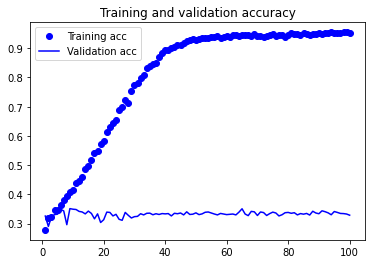

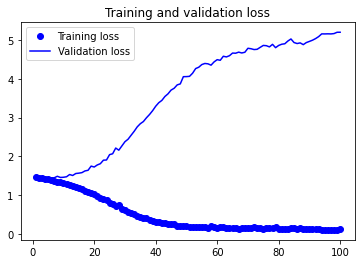

In [73]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
